# Simulation-Based/Likelihood-Free Inference Quick Start
We would like to perform inference on a model's parameters $\theta$ given observations $\{x\}_i$ :
$$
P\left(\theta \mid\{x\}_i\right)
$$
which relies on the likelihood function $
P\left(\{x\}_i \mid \theta\right)
$, However, what if we don't know the likelihood? What if all we can do is simulate outputs $x$ given $\theta$ ?
$$
x \sim \operatorname{Simulator}(\theta)
$$
Well, say we take this simulator, and can simulate enough examples such that we can measure the frequency of examples reproducing the data (or getting close to it). 



<img src="img/sbi.png" alt="NF" style="width: 80%; height: 80%;">




But, what if the simulation is very expensive, and the data is high dimensional? Then we would need to run far too many simulations. E.g., images of a galaxy - we can't simply simulate enough galaxies until the pixels match up!

So we turn to Likelihood-Free Inference. Instead of needing to call the simulation over and over, we instead run it only a few times, and fit a function:
$$
P(\theta \mid x)
$$
for several examples of $\{\theta, x\}_i$, such that $\sum_i \log P(\theta \mid x)$ is maximized over the data.

# Inference on Hodgkin-Huxley model: tutorial

In this tutorial, we use `sbi` to do inference on a [Hodgkin-Huxley model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) from neuroscience (Hodgkin and Huxley, 1952). We will learn two parameters ($\bar g_{Na}$,$\bar g_K$) based on a current-clamp recording, that we generate synthetically (in practice, this would be an experimental observation).

First we are going to import basic packages.

In [1]:
import numpy as np
import brainpy as bp
import brainpy.math as bm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"  # specify which GPU(s) to be used
bm.disable_gpu_memory_preallocation()
bm.set_platform('gpu')
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from HH_helper_bp import *

# For SNPE：posterior_nn(). SNLE: likelihood_nn(). For SNRE: classifier_nn(), 
# sbi
from sbi.inference import SNPE, SNRE, SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn, likelihood_nn, classifier_nn
from sbi import utils as utils
from sbi import analysis as analysis
from scipy.stats import kurtosis as kurt
from sbi.utils.user_input_checks import process_pytorch_prior, process_simulator

/home/spirit/anaconda3/envs/winsch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Different required components

Before running inference, let us define the different required components:

1. observed data
1. prior over model parameters
2. simulator

## 1. Observed data

Let us assume we current-clamped a neuron and recorded the following voltage trace:

<img src="img/observed_voltage_trace.png" alt="ovt.png" width="60%">

In fact, this voltage trace was not measured experimentally but synthetically generated by simulating a Hodgkin-Huxley model with particular parameters ($\bar g_{Na}$,$\bar g_K$). We will come back to this point later in the tutorial.

## 2. Simulator

We would like to infer the posterior over the two parameters ($\bar g_{Na}$,$\bar g_K$) of a Hodgkin-Huxley model, given the observed electrophysiological recording above. The model has channel kinetics as in [Pospischil et al. 2008](https://link.springer.com/article/10.1007/s00422-008-0263-8), and is defined by the following set of differential equations (parameters of interest highlighted in orange):

$$
\scriptsize
\begin{align}
C_m\frac{dV}{dt}&=g_1\left(E_1-V\right)+
                    \color{orange}{\bar{g}_{Na}}m^3h\left(E_{Na}-V\right)+
                    \color{orange}{\bar{g}_{K}}n^4\left(E_K-V\right)+
                    \bar{g}_Mp\left(E_K-V\right)+
                    I_{inj}+
                    \sigma\eta\left(t\right)\\
\frac{dq}{dt}&=\frac{q_\infty\left(V\right)-q}{\tau_q\left(V\right)},\;q\in\{m,h,n,p\}
\end{align}
$$

Above, $V$ represents the membrane potential, $C_m$ is the membrane capacitance, $g_{\text{l}}$ is the leak conductance, $E_{\text{l}}$ is the membrane reversal potential, $\bar{g}_c$ is the density of channels of type $c$ ($\text{Na}^+$, $\text{K}^+$, M), $E_c$ is the reversal potential of $c$, ($m$, $h$, $n$, $p$) are the respective channel gating kinetic variables, and $\sigma \eta(t)$ is the intrinsic neural noise. The right hand side of the voltage dynamics is composed of a leak current, a voltage-dependent $\text{Na}^+$ current, a delayed-rectifier $\text{K}^+$ current, a slow voltage-dependent $\text{K}^+$ current responsible for spike-frequency adaptation, and an injected current $I_{\text{inj}}$. Channel gating variables $q$ have dynamics fully characterized by the neuron membrane potential $V$, given the respective steady-state $q_{\infty}(V)$ and time constant $\tau_{q}(V)$ (details in Pospischil et al. 2008).

The input current $I_{\text{inj}}$ is defined as

In [2]:
A_soma = bm.pi * ((70.0 * 1e-4) ** 2)  # cm2
I_current_amplitude = 0.5/(A_soma * 1e3) # muA/cm2
t_on = 10
t_off = 110
sim_duration = 100
dt    = 0.1
syn_current, duration = bp.inputs.section_input(values=[0, I_current_amplitude, 0.],
                                                durations=[t_on, sim_duration, t_off - sim_duration],
                                                return_length=True,
                                                dt= dt)

We define a function that performs all of the above steps at once. The Hodgkin-Huxley simulator is given by:

In [3]:
def run_HH_model(params):
    params = bm.asarray(params)
    t = np.arange(0, len(syn_current), 1) * dt
    neuron = HH_sbi(size= params.shape[0])
    neuron.gNa   = params[:,0]
    neuron.gK    = params[:,1]
    # neuron.gL    = params[:,2]
    # neuron.C     = params[:,3]

    runner = bp.DSRunner(
        neuron, 
        monitors=['spike', 'V'], 
        inputs=('input', syn_current,'iter'),  # constant external inputs of 22 mA to all neurons
        dt=dt,
        progress_bar=False
    )
    runner.run(duration)  # the running time is 200 ms
    return dict(data = runner.mon.V.T, spikes = runner.mon.spike.T, time = t, dt = dt)

Often, we are not interested in matching the exact trace, but only in matching certain features thereof. In this example of the Hodgkin-Huxley model, the summary features are the number of spikes, the mean resting potential, the standard deviation of the resting potential, and the first four voltage moments: mean, standard deviation, skewness and kurtosis. Using the function `calculate_summary_statistics()` imported below, we obtain these statistics from the output of the Hodgkin Huxley simulator.  The function `simulation_wrapper` takes in conductance values, runs the Hodgkin Huxley model and then returns the summary statistics.

In [4]:
time_to_first_spike = lambda x: np.where(x)[0][0] if np.any(x) else 0
def compute_mean_isi(neuron_spikes):
    spike_times = np.where(neuron_spikes)[0]
    if len(spike_times) > 1:
        intervals = np.diff(spike_times)
        return np.mean(intervals)
    else:
        return 0.

def calculate_summary_statistics(x):
    v =  np.array(x["data"])
    t = x["time"]
    dt = x["dt"]
    # v[v < -10] = -10
    # diff_v = np.diff(v, axis=1)
    # v[:, :-1][diff_v < 0] = -10

    # Resting potential and std
    rest_pot = np.mean(v[:, t < t_on], axis=1)
    rest_pot_std = np.std(v[:, int(0.8 * t_on / dt):int(t_on / dt)], axis=1)
    
    # Mean and standard deviation during stimulation
    v_stim = v[:, (t > t_on) & (t < t_off)]
    mean_v_stim = np.mean(v_stim, axis=1)
    std_v_stim  = np.std(v_stim, axis=1)

    # spike calculation
    spike_counts = x['spikes'].sum(axis=1)
    mean_isi_values = np.apply_along_axis(compute_mean_isi, axis=1, arr=x['spikes']) * dt
    first_spike_times = np.apply_along_axis(time_to_first_spike, axis=1, arr=x['spikes']) * dt

    sum_stats_vec = np.column_stack((
        spike_counts,
        mean_isi_values,
        first_spike_times,
        rest_pot,
        rest_pot_std,
        mean_v_stim,
        std_v_stim,
    ))
    return sum_stats_vec

def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    Summarizes the output of the simulation and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats.to(torch.float32)

To get an idea of the output of the Hodgkin-Huxley model, let us generate some voltage traces for different parameters ($\bar g_{Na}$,$\bar g_K$), given the input current $I_{\text{inj}}$:

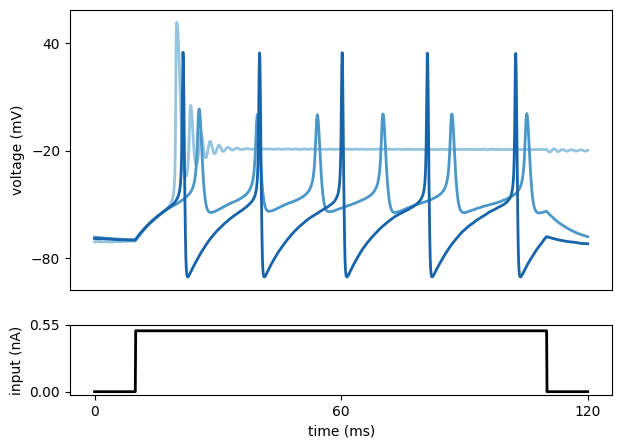

In [5]:
# three sets of (g_Na, g_K)
params = np.array([[50.0, 1.0], [4.0, 1.5], [20.0, 15.0]])

# three sets of (g_Na, g_K, g_L, C)
# params = np.array([[50.0, 1.0, 0.1, 1.0],[4.0, 1.5, 0.1, 1.0], [20.0, 15.0, 0.1, 1.0]])

num_samples = len(params[:, 0])
sim_samples = np.zeros((num_samples, len(syn_current)))
for i in range(num_samples):
    sim_samples[i, :] = run_HH_model(params= params[i, :].reshape(1, -1))["data"].squeeze()


# colors for traces
col_min = 2
num_colors = num_samples + col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.0 * i / num_colors) for i in range(col_min, num_colors)]
t    = np.arange(0, len(syn_current), 1) * dt

fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t, sim_samples[i, :], color=col1[i], lw=2)
plt.ylabel("voltage (mV)")
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t, syn_current * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(t) / 2, max(t)])
ax.set_yticks([0, 1.1 * np.max(syn_current * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))
plt.show()

As can be seen, the voltage traces can be quite diverse for different parameter values.

`sbi` takes any function as simulator. Thus, `sbi` also has the flexibility to use simulators that utilize external packages, e.g., Brian (http://briansimulator.org/), nest (https://www.nest-simulator.org/), or NEURON (https://neuron.yale.edu/neuron/). External simulators do not even need to be Python-based as long as they store simulation outputs in a format that can be read from Python. All that is necessary is to wrap your external simulator of choice into a Python callable that takes a parameter set and outputs a set of summary statistics we want to fit the parameters to.

## 3. Prior over model parameters

Now that we have the simulator, we need to define a function with the prior over the model parameters ($\bar g_{Na}$,$\bar g_K$), which in this case is chosen to be a Uniform distribution:

In [6]:
prior_min = [0.5, 1e-4]
prior_max = [80.0, 15.0]

# parameters(g_Na, g_K, g_L, C)
# prior_min = [0.5, 1e-4, 1e-4, 1e-1]
# prior_max = [80.0, 15.0, 15.0, 3.0]

prior = utils.torchutils.BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

## Inference
Now that we have all the required components, we can run inference with SNPE to identify parameters whose activity matches this trace.

In [7]:
# Simulate samples from the prior distribution
num_rounds = 2
posteriors = []
proposal = prior

true_params = np.array([[50., 5.]])

# true_params = np.array([[50.0, 5.0, 0.1, 1.0]])  # (g_Na, g_K, g_L, C, g_M, V_th)    
true_data = run_HH_model(true_params)
xo = calculate_summary_statistics(true_data)
xo = torch.tensor(xo, dtype=torch.float32)

for _ in range(num_rounds):
    theta = proposal.sample((1200,))
    stats = simulation_wrapper(theta)
    print('done.')
    density_estimator_build_fun = utils.posterior_nn(model='mdn')
    inference = SNPE(prior, density_estimator=density_estimator_build_fun)

    print('Training inference network... ')
    inference.append_simulations(theta, stats).train()
    posterior = inference.build_posterior()
    posteriors.append(posterior)
    proposal = posterior.set_default_x(xo)


done.
Training inference network... 
 Neural network successfully converged after 253 epochs.

Drawing 1200 posterior samples: 100%|██████████| 1200/1200 [00:00<00:00, 131061.76it/s]


done.
Training inference network... 
 Neural network successfully converged after 51 epochs.

### Coming back to the observed data
As mentioned at the beginning of the tutorial, the observed data are generated by the Hodgkin-Huxley model with a set of known parameters ($\bar g_{Na}$,$\bar g_K$). To illustrate how to compute the summary statistics of the observed data, let us regenerate the observed data:

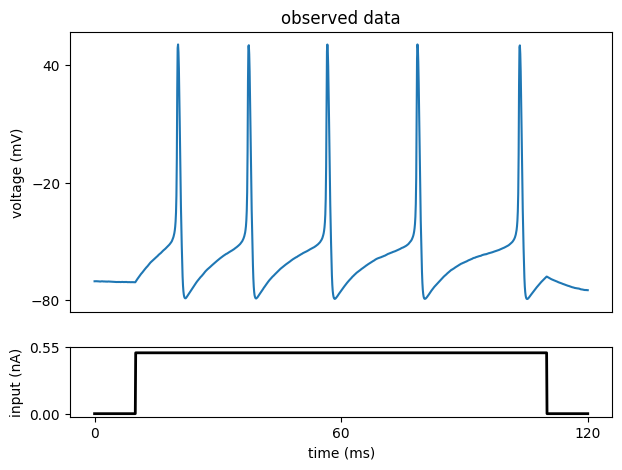

In [8]:
# true parameters and respective labels
fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
plt.plot(true_data["time"], true_data["data"].squeeze())
plt.ylabel("voltage (mV)")
plt.title("observed data")
plt.setp(ax, xticks=[], yticks=[-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(true_data["time"], syn_current * A_soma * 1e3, "k", lw=2)
plt.xlabel("time (ms)")
plt.ylabel("input (nA)")

ax.set_xticks([0, max(true_data["time"]) / 2, max(true_data["time"])])
ax.set_yticks([0, 1.1 * np.max(syn_current * A_soma * 1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter("%.2f"))

In [9]:
samples = posterior.sample((10000,), x=xo)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 212896.94it/s]


## Analysis of the posterior given the observed data

After running the inference algorithm, let us inspect the inferred posterior distribution over the parameters ($\bar g_{Na}$,$\bar g_K$), given the observed trace. To do so, we first draw samples (i.e. consistent parameter sets) from the posterior:

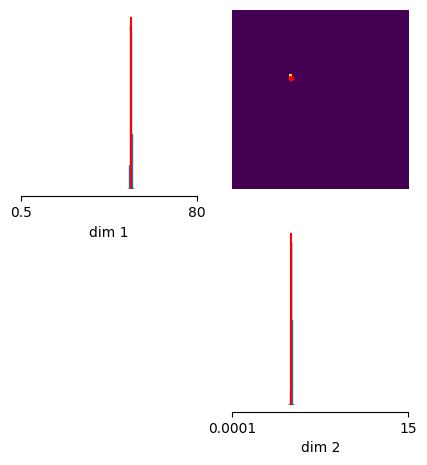

In [10]:
labels_params = [r"$g_{Na}$", r"$g_{K}$"]
fig, axes = analysis.pairplot(
    samples,
    limits=[[0.5, 80], [1e-4, 15.0]],
    ticks=[[0.5, 80], [1e-4, 15.0]],
    figsize=(5, 5),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
);

# labels_params = [r"$g_{Na}$", r"$g_{K}$", r"$g_{L}$", r"$C$"]
# fig,axes = analysis.pairplot(
#      samples,
#      limits= [[0.5, 80], [1e-4, 15.0], [1e-4, 15.0], [1e-1, 3.0]],
#         ticks=[[0.5, 80], [1e-4, 15.0], [1e-4, 15.0], [1e-1, 3.0]],
#         figsize=(10, 10),
#         points=true_params,
#         labels= labels_params,
#         points_offdiag={"markersize": 6},
#         points_colors="r",
# )

As can be seen, the inferred posterior contains the ground-truth parameters (red) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for this parameter set and compare the simulations with the observed data:As can be seen, the inferred posterior contains the ground-truth parameters (red) in a high-probability region. Now, let us sample parameters from the posterior distribution, simulate the Hodgkin-Huxley model for this parameter set and compare the simulations with the observed data:

In [11]:
posterior_sample = posterior.sample((1,), x=xo).numpy()

Drawing 1 posterior samples: 100%|██████████| 1/1 [00:00<00:00, 659.38it/s]


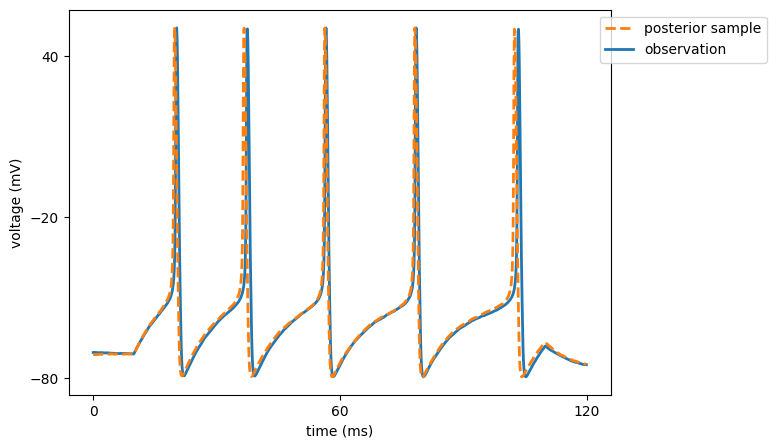

In [12]:
fig = plt.figure(figsize=(7, 5))

# plot observation
t = true_data["time"]
y_obs = true_data["data"].squeeze()
plt.plot(t, y_obs, lw=2, label="observation")

# simulate and plot samples
x = run_HH_model(posterior_sample)
plt.plot(t, x["data"].squeeze(), "--", lw=2, label="posterior sample")

plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), loc="upper right")

ax.set_xticks([0, 60, 120])
ax.set_yticks([-80, -20, 40]);

As can be seen, the sample from the inferred posterior leads to simulations that closely resemble the observed data, confirming that `SNPE` did a good job at capturing the observed data in this simple case.As can be seen, the sample from the inferred posterior leads to simulations that closely resemble the observed data, confirming that `SNPE` did a good job at capturing the observed data in this simple case.

## References


A. L. Hodgkin and A. F. Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve. The Journal of Physiology, 117(4):500–544, 1952.

M. Pospischil, M. Toledo-Rodriguez, C. Monier, Z. Piwkowska, T. Bal, Y. Frégnac, H. Markram, and A. Destexhe. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biological Cybernetics, 99(4-5), 2008.